# Астероиды и кометы

## Заложим основы

In [158]:
import numba as nb
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unittest
from pathlib import Path
from PIL import Image
from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
from IPython import display
from tqdm import tqdm
from dataclasses import dataclass
from numba import njit

dt = 1e-3
G = 6.7e-11
au = 149597870700

InteractiveShell.ast_node_interactivity = "all"

### Зададим объект
В моей программе только один класс, поскольку принципиальных различий между реальными небесными телами нет

In [159]:
@dataclass
class CosmicBody:   
    mass: float
    obj_radius: float
    radius_vec: np.array
    velocity_vec: np.array


### Зададим методы
Их будет всего два:
- Рассчёт изменений всех параметров системы за dt (учитывает 2 возможных сценария: смещение и столкновение)
- Определение типа траектории

In [160]:
#@njit
def dtChange(syst):
    for i in range(len(syst)):
        syst[i].radius_vec += np.dot(dt, syst[i].velocity_vec)

        
    for i in range(len(syst)):
        for j in range(len(syst)):
            if j != i:
                dr = np.array(syst[j].radius_vec) - np.array(syst[i].radius_vec)
                syst[i].velocity_vec += np.dot(G*dt/(np.linalg.norm(dr)**3)*syst[j].mass, dr)
    
    for i in range(len(syst)):
        for j in range(len(syst)) :
            if syst[i].mass >= syst[j].mass:
                dr = np.array(syst[j].radius_vec) - np.array(syst[i].radius_vec)
                if np.linalg.norm(dr) < syst[i].obj_radius:
                    syst[i].mass += syst[j].mass
                    syst[i].radius_vec += np.dot(syst[j].mass/(syst[j].mass+syst[i].mass), dr)
                    syst[i].obj_radius *= (1 + (syst[i].mass / syst[j].mass)) ** (1/3)
                    syst[j].mass = 0
                    syst[j].obj_radius = 0
                    syst[j].velocity_vec = 0
                    syst[j].radius_vec = 0

In [161]:
def OrbitType(CosmicBody):

IndentationError: expected an indented block (Temp/ipykernel_40636/1590042221.py, line 1)

In [164]:
def plotter(syst):
        """
        The basic function to plot orbits of bodies.
        Can be used for 2 and 3 dimensional space.
        Show plot.

        Parameters
        ----------
        syst : list of objects of class Body
        """
        

        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)

        x = syst[0].obj_radius * np.outer(np.cos(u), np.sin(v))
        y = syst[0].obj_radius * np.outer(np.sin(u), np.sin(v))
        z = syst[0].obj_radius * np.outer(np.ones(np.size(u)), np.cos(v))
        plt.plot_surface(x, y, z, rstride=4, cstride=4, color='r', linewidth=0, alpha=0.5)
        plt.plot_surface(x, y, -z, rstride=4, cstride=4, color='r', linewidth=0, alpha=0.5)

        X_coord = [None] * len(syst) * 1000000
        Y_coord = [None] * len(syst) * 1000000
        Z_coord = [None] * len(syst) * 1000000

        for _ in range(1000):
                dtChange(syst)
                for i in range(len(syst)):
                        X_coord.append(syst[i].radius_vec[0])
                        Y_coord.append(syst[i].radius_vec[1])
                        Z_coord.append(syst[i].radius_vec[2])

        for i in range(len(syst)):
                plt.scatter(, , s=1)
        plt.show()

SyntaxError: invalid syntax (Temp/ipykernel_40636/565488193.py, line 34)

### Тесты

TypeError: 'int' object is not subscriptable

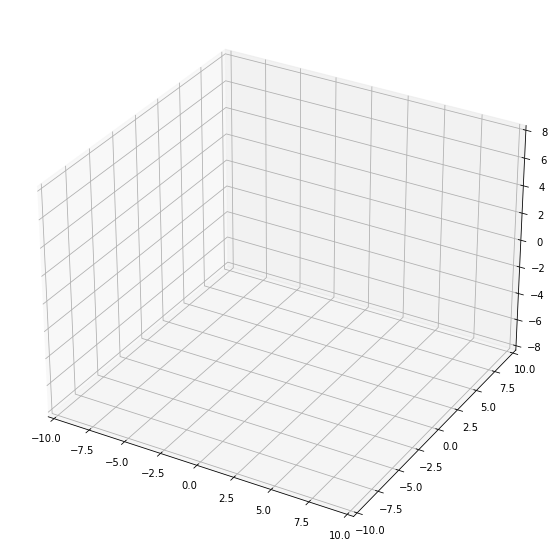

In [165]:
#                  mass     obj_radius  radius_vec      velocity_vec   
Big   = CosmicBody(100,     2,          [0,0,0],        [0, 0, 0]    ) 
Body1 = CosmicBody(0.5,     0.125,      [3, 0, 1],      [0, -0.5, 10])
Body2 = CosmicBody(20,      0.15,       [0, 0, 3],      [10, 0, 0]   )
Body3 = CosmicBody(5,       0.5,        [7, 0, 5],      [5, 0, -2]   )

syst  = [Big, Body1, Body2, Body3]

for _ in range(1000):
    dtChange(syst)
plotter(syst)
